In [1]:
#Load libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
META=pd.read_csv('SUBJECT_METADTA.txt', sep="\t", index_col=0) # Sample metadata
xs=pd.read_csv('HMP2_SamplesWithMetadata.Genus.txt', sep="\t", index_col=0) # relative abundances
metx=pd.read_csv('HMP2_SamplesWithMetadata.Metabs.txt', sep="\t", index_col=0) # metabolite abundances
metx=np.log10(metx+1)

In [3]:
#convert metabolites to z scores
mu_met = metx.mean();sg_met = metx.std();
metz=metx.subtract(mu_met).divide(sg_met)

In [4]:
#keep data from individuals with at least 2 samples
sel=META.groupby('host_subject_id').count()[META.groupby('host_subject_id').count()['Host_Age']>1].index

In [5]:
def sensitivity_matrices_shared_latents(Q,thet,C,Kc,index):
    #a = Km + Kc
    a, nMet = C.shape;
    Km = a - Kc; # Free metadata latents
    #b = Kq + Kc
    b, nO = thet.shape;
    Kq = b - Kc; # Free microbiome latents
    Ktot = Kq + Km + Kc;
    print([Kq, Kc, Km])
    # Initialize bigger C and theta matrices, some of whose rows are zeros. 
    bigC = np.zeros((Ktot,nMet));
    bigT = np.zeros((Ktot,nO));
    bigC[Kq:,:]  = C;
    bigT[0:Kq+Kc,:] = thet; 
    nSamp = Q.shape[0];
    log_sens={}
    sens={}
    for s in range(nSamp):
        q=Q[s,:]
        tav=np.matmul(q,bigT.transpose()).reshape(Ktot,1)
        DeltalQ = -bigT + tav #For sensitivity matrix for log-fold change in abundance  #CHECK
        DeltaQ= DeltalQ*q #For sensitivity matrix for absolute change in abundance
        iDeltlQ=np.linalg.pinv(DeltalQ)
        iDeltQ =np.linalg.pinv(DeltaQ)
        log_sens[index[s]]=np.matmul(iDeltlQ,bigC)
        sens[index[s]] = np.matmul(iDeltQ,bigC)
        #print(s)
    return log_sens, sens

In [6]:
#load model (trained on one sample per subject [only subjects with metadata])
filen='HMP2_18_2_0_18567_6.64e+02.pickle'
with open(filen,'rb') as f:
        model=pickle.load(f)


In [7]:
#calculate matrices
log_sens, sens=sensitivity_matrices_shared_latents(model['Q'],
                                                   model['thet'][0:model['nQ']+model['nC'],:],
                                                   model['C'][model['nQ']:,:],
                                                   model['nC'],
                                                   model['xs'].index);

[2, 18, 0]


In [8]:
#retrieve training data from model only for filtered subjects
train=model['xs'].loc[model['xs'].index[model['xs'].index.isin(META.index[META.host_subject_id.isin(sel)])]]
trainmetz=model['metz'].loc[model['xs'].index[model['xs'].index.isin(META.index[META.host_subject_id.isin(sel)])]]

In [9]:
#retrieve model parameters for filtered subjects
trainpos=np.argwhere(model['xs'].index.isin(train.index))
Z=model['Z'][trainpos,:]
Q=model['Q'][trainpos,:]

In [10]:
#define testing data (remaining samples from selected subjects)
testids=META.index[(META.host_subject_id.isin(sel))&(~META.host_subject_id.isin(train.index))]
test=xs.loc[testids]
testmetz=metz.loc[testids]

In [11]:
# Latent space embedding the testing data
nTest=len(test.index)
nQ=model['nQ']
nC=model['nC']
ths=model['thet'][0:nQ+nC,:]
Ztest = 0.1*np.random.randn(nTest,nC+nQ);
eta = 0.005;
for i in range(10000):
    f=np.matmul(Ztest,ths)
    Qtest=np.exp(-f)
    Qtest=np.divide(Qtest.transpose(),Qtest.sum(axis=1)).transpose()
    delt=test.values-Qtest
    grz=np.matmul(delt,ths.transpose())
    Ztest=Ztest-eta*grz

In [12]:
#accuracy of sign changes for samples of same individual (at least 2 SD difference)
#Only comparisons within same individual, include closest interaction matrix + 3 random matrices

signprderr=pd.DataFrame(columns=['sensitivity_matrix','prediction','acc','dZ','type'])
count=1
for i in range(len(train.index)):
    for j in range(len(test.index)):
        dQ=Qtest[j,:]-Q[i,:]
        #if np.linalg.norm(dQ)>0.2: ## No cutoff, just changes within an individual
        #    continue
        if META.loc[train.index[i],'host_subject_id'] != META.loc[test.index[j],'host_subject_id']:
            continue
            
        #using matrix from self
        dZ=np.linalg.norm(Z[i,:]-Ztest[j,:])
        M=testmetz.loc[test.index[j],:]
        dMprd=np.matmul(dQ,sens[train.index[i]])
        PRD=dMprd[0]+trainmetz.iloc[i,:]
        true_pos=((M-trainmetz.iloc[i,:])>2).astype(int)
        true_neg=((M-trainmetz.iloc[i,:])<-2).astype(int)
        pred_pos=((PRD-trainmetz.iloc[i,:])>2).astype(int)
        pred_neg=((PRD-trainmetz.iloc[i,:])<-2).astype(int)
        true_sign=true_pos+true_neg*-1
        pred_sign=pred_pos+pred_neg*-1
        acc=sum((true_sign==pred_sign))/len(true_sign)
        signprderr.loc[count,:]=[META.loc[train.index[i],'host_subject_id'],META.loc[test.index[j],'host_subject_id'],acc,dZ,'same']
        count+=1
        
        
        #using closest non-self interaction matrix
        dz=1e9
        closest=0
        for k in range(len(train.index)):
            if k==i:
                continue
            ddz=np.linalg.norm(Z[k,:]-Z[i,:]) #ddz=np.linalg.norm(Z[k,:]-Ztest[j,:])
            if ddz<dz:
                dz=ddz
                closest=k
        dZ=dz
        M=testmetz.loc[test.index[closest],:]
        dMprd=np.matmul(dQ,sens[train.index[i]])
        PRD=dMprd[0]+trainmetz.iloc[i,:]
        true_pos=((M-trainmetz.iloc[i,:])>2).astype(int)
        true_neg=((M-trainmetz.iloc[i,:])<-2).astype(int)
        pred_pos=((PRD-trainmetz.iloc[i,:])>2).astype(int)
        pred_neg=((PRD-trainmetz.iloc[i,:])<-2).astype(int)
        true_sign=true_pos+true_neg*-1
        pred_sign=pred_pos+pred_neg*-1
        acc=sum((true_sign==pred_sign))/len(true_sign)
        signprderr.loc[count,:]=[META.loc[train.index[i],'host_subject_id'],META.loc[test.index[j],'host_subject_id'],acc,dZ,'closest']
        count+=1
        
        #add three random ones
        order=np.random.permutation(range(len(train.index)))
        for k in range(3):
            dZ=np.linalg.norm(Z[order[k],:]-Z[i,:]) # np.linalg.norm(Z[order[k],:]-Ztest[j,:])
            M=testmetz.loc[test.index[j],:]
            dMprd=np.matmul(dQ,sens[train.index[order[k]]])
            PRD=dMprd[0]+trainmetz.iloc[i,:]
            true_pos=((M-trainmetz.iloc[i,:])>2).astype(int)
            true_neg=((M-trainmetz.iloc[i,:])<-2).astype(int)
            pred_pos=((PRD-trainmetz.iloc[i,:])>2).astype(int)
            pred_neg=((PRD-trainmetz.iloc[i,:])<-2).astype(int)
            true_sign=true_pos+true_neg*-1
            pred_sign=pred_pos+pred_neg*-1
            acc=sum((true_sign==pred_sign))/len(true_sign)
            signprderr.loc[count,:]=[META.loc[train.index[order[k]],'host_subject_id'],META.loc[test.index[j],'host_subject_id'],acc,dZ,'different']
            count+=1

In [13]:
#summarize prediction accuracy by individual

by_inds=pd.DataFrame(columns=['subject','acc','dZ','type'])
count=0
x=signprderr[['prediction','acc','dZ']][signprderr.type=='same'].groupby('prediction').mean()
for i in x.index:
    by_inds.loc[count,:]=[i,x.loc[i,'acc'],x.loc[i,'dZ'],'self']
    count+=1

x=signprderr[['prediction','acc','dZ']][signprderr.type=='closest'].groupby('prediction').mean() ####
for i in x.index:
    by_inds.loc[count,:]=[i,x.loc[i,'acc'],x.loc[i,'dZ'],'closest non-self']
    count+=1
    
x=signprderr[['prediction','acc','dZ']][signprderr.type=='different'].groupby('prediction').mean()
for i in x.index:
    by_inds.loc[count,:]=[i,x.loc[i,'acc'],x.loc[i,'dZ'],'non-self']
    count+=1


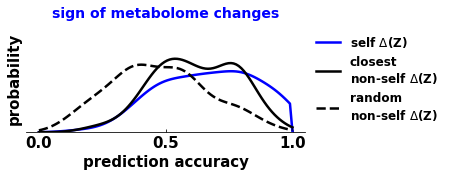

In [14]:
#histograms
self=list(by_inds.acc[by_inds.type=='self'].values)
nonself=list(by_inds.acc[by_inds.type=='non-self'].values)
closest=list(by_inds.acc[by_inds.type=='closest non-self'].values)
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(self)
#kde.set_bandwidth(0.5)
x = np.linspace(np.min(self+[0]), np.max(self+[1]), 100)
y=kde(x); y[-1]=0
ax=sns.lineplot(x=x, y=y,color='b',linewidth=2.5, label='self '+ r'$\Delta$'+'(Z)')

kde=stats.gaussian_kde(closest)
x = np.linspace(np.min(closest+[0]), np.max(closest+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5,linestyle='-', label='closest\nnon-self '+ r'$\Delta$'+'(Z)')

kde=stats.gaussian_kde(nonself)
x = np.linspace(np.min(nonself+[0]), np.max(nonself+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5,linestyle='--', label='random\nnon-self '+ r'$\Delta$'+'(Z)')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('prediction accuracy', fontsize=15,fontweight='bold')
ax.set_ylim(0,3)
ax.set_title('sign of metabolome changes', fontweight='bold', fontsize=14, color='b')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(1,1))
ax.set_xticks([0, 0.5,1])
ax.set_xticks([0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15, direction='in')
plt.xticks(weight = 'bold');

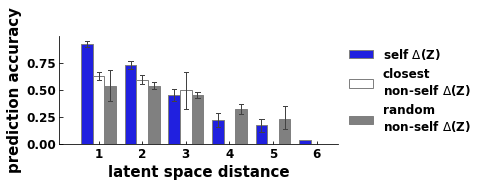

In [15]:
signprderr.loc[:,'zbin']=pd.cut(signprderr['dZ'], bins=pd.interval_range(start=0, end=8, freq=1))
fig,ax=plt.subplots(figsize=(5,2))
ax=sns.barplot(x='zbin', y='acc', hue='type', data=signprderr, ci=96, edgecolor=".5", 
               capsize=.1, linewidth=1, errwidth=1, palette=['b','w','gray'])
ax.set_xlim((0.1,6.5))
#ax.set_ylim((0,1.2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False,bbox_to_anchor=(1,1))
leg = ax.get_legend()
new_labels = ['self '+ r'$\Delta$'+'(Z)', 'closest\nnon-self '+ r'$\Delta$'+'(Z)', 'random\nnon-self '+ r'$\Delta$'+'(Z)']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
ax.set_ylabel('prediction accuracy', fontsize=15, fontweight='bold')
ax.set_xlabel('latent space distance', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', which='major', labelsize=12, direction='in')
ax.tick_params(axis='y', which='major', labelsize=12, direction='in')
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels([1,2,3,4,5,6])
plt.xticks(weight = 'bold');
plt.yticks(weight = 'bold');

In [16]:
#accuracy of changes in a specific metabolite
#Only comparisons within same individual, include closest interaction matrix + 3 random matrices
q='butyrate'
phid=list(trainmetz.columns).index('butyrate')
prderrq=pd.DataFrame(columns=['sensitivity_matrix','prediction','error','dZ','type'])
count=1
for i in range(len(train.index)):
    for j in range(len(test.index)):
        
        dQ=Qtest[j,:]-Q[i,:]
        if META.loc[train.index[i],'host_subject_id'] != META.loc[test.index[j],'host_subject_id']:
            continue
        #if np.linalg.norm(dQ)>0.2:
        #    continue
        #using matrix from self
        dZ=np.linalg.norm(Z[i,:]-Ztest[j,:])
        M=testmetz.loc[test.index[j],q]
        dMprd=np.matmul(dQ,sens[train.index[i]])
        PRD=dMprd[0][phid]+trainmetz.iloc[i,phid]
        err=np.log10(abs(M-PRD))
        prderrq.loc[count,:]=[META.loc[train.index[i],'host_subject_id'],META.loc[test.index[j],'host_subject_id'],err,dZ,'same']        
        count+=1
        
        #using closest non-self interaction matrix
        dz=1e9
        closest=0
        for k in range(len(train.index)):
            if k==i:
                continue
            ddz=np.linalg.norm(Z[k,:]-Z[i,:]) #np.linalg.norm(Z[k,:]-Ztest[j,:])
            if ddz<dz:
                dz=ddz
                closest=k
        dZ=dz
        M=testmetz.loc[test.index[closest],q]
        dMprd=np.matmul(dQ,sens[train.index[i]])
        PRD=dMprd[0][phid]+trainmetz.iloc[i,phid]
        err=np.log10(abs(M-PRD))
        prderrq.loc[count,:]=[META.loc[train.index[i],'host_subject_id'],META.loc[test.index[j],'host_subject_id'],err,dZ,'closest']        
        count+=1
        
        order=np.random.permutation(range(len(train.index)))
        for k in range(3):
            dZ=np.linalg.norm(Z[order[k],:]-Z[i,:]) #np.linalg.norm(Z[order[k],:]-Ztest[j,:])
            M=testmetz.loc[test.index[j],q]
            dMprd=np.matmul(dQ,sens[train.index[order[k]]])
            PRD=dMprd[0][phid]+trainmetz.iloc[i,phid]
            err=np.log10(abs(M-PRD))
            prderrq.loc[count,:]=[META.loc[train.index[order[k]],'host_subject_id'],META.loc[test.index[j],'host_subject_id'],err,dZ,'different']
            count+=1
        

In [17]:
by_indq=pd.DataFrame(columns=['subject','error','dZ','type'])
count=0
x=prderrq[['prediction','error','dZ']][prderrq.type=='same'].groupby('prediction').mean()
for i in x.index:
    by_indq.loc[count,:]=[i,x.loc[i,'error'],x.loc[i,'dZ'],'self']
    count+=1
x=prderrq[['prediction','error','dZ']][prderrq.type=='closest'].groupby('prediction').mean()
for i in x.index:
    by_indq.loc[count,:]=[i,x.loc[i,'error'],x.loc[i,'dZ'],'closest non-self']
    count+=1
x=prderrq[['prediction','error','dZ']][prderrq.type=='different'].groupby('prediction').mean()
for i in x.index:
    by_indq.loc[count,:]=[i,x.loc[i,'error'],x.loc[i,'dZ'],'non-self']
    count+=1

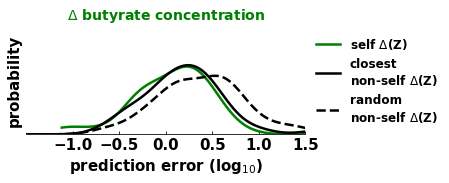

In [18]:
#histograms
selfq=list(by_indq.error[by_indq.type=='self'].values)
nonselfq=list(by_indq.error[by_indq.type=='non-self'].values)
closestq=list(by_indq.error[by_indq.type=='closest non-self'].values)
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(selfq)
#kde.set_bandwidth(0.5)
x = np.linspace(np.min(selfq+[0]), np.max(selfq+[1]), 100)
y=kde(x); y[-1]=0
ax=sns.lineplot(x=x, y=y,color='g',linewidth=2.5, label='self '+ r'$\Delta$'+'(Z)')

kde=stats.gaussian_kde(closestq)
x = np.linspace(np.min(closestq+[-1.5]), np.max(closestq+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5,linestyle='-', label='closest\nnon-self '+ r'$\Delta$'+'(Z)')

kde=stats.gaussian_kde(nonselfq)
x = np.linspace(np.min(nonselfq+[-1.5]), np.max(nonselfq+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5,linestyle='--', label='random\nnon-self '+ r'$\Delta$'+'(Z)')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('prediction error (log'+r'$_{10}$'+')', fontsize=15,fontweight='bold')
ax.set_ylim(0,1.5)
ax.set_title(r'$\Delta$'+' butyrate concentration', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(1,1))
ax.set_xticks([-1,-0.5, 0, 0.5,1,1.5])
ax.set_xlim(-1.5,1.5)
ax.tick_params(axis='x', which='major', labelsize=15, direction='in')
plt.xticks(weight = 'bold');

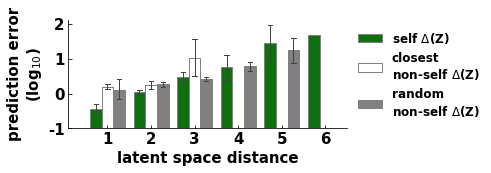

In [19]:
prderrq.loc[:,'error1']=prderrq.loc[:,'error']+1
prderrq.loc[:,'zbin']=pd.cut(prderrq['dZ'], bins=pd.interval_range(start=0, end=8))
fig,ax=plt.subplots(figsize=(5,2))
ax=sns.barplot(x='zbin', y='error1', hue='type', data=prderrq, ci=95, edgecolor=".5", 
               capsize=.1, linewidth=1, errwidth=1, palette=['g','w','gray'])
ax.set_xlim((0.1,6.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False,bbox_to_anchor=(1,1))
leg = ax.get_legend()
new_labels = ['self '+ r'$\Delta$'+'(Z)', 'closest\nnon-self '+ r'$\Delta$'+'(Z)', 'random\nnon-self '+ r'$\Delta$'+'(Z)']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
ax.set_ylabel('prediction error\n(log'+r'$_{10}$'+')', fontsize=15, fontweight='bold')
ax.set_xlabel('latent space distance', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', which='major', labelsize=15, direction='in')
ax.tick_params(axis='y', which='major', labelsize=15, direction='in')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2])
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels([1,2,3,4,5,6])
ax.spines['bottom'].set_position(('axes', 0))
plt.xticks(weight = 'bold');
plt.yticks(weight = 'bold');